In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib
from matplotlib.lines import Line2D
import matplotlib.gridspec as gridspec
plt.style.use('lato_style.mplstyle')

import fidimag.common.constant as C

import os, shutil, glob, re

/home/david/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)
/home/david/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


In [4]:
# import imp
# imp.reload(npt)

In [5]:
base_folder = 'hexagonal_system/NEBM/nebm_2Dhex_hexagons_PdFe-Ir_tgt-st-up_sk-down_B-sweep_DT/'

energy_barriers = {}
energy_bands = {}
distances = {}
energy_bands_interp = {}

R_range = np.array([14, 12, 10, 8, 6])
B_range = np.arange(0, 1201, 100)

for R in R_range:
    
    energy_barriers[R] = {}
    energy_bands[R] = {}
    distances[R] = {}
    energy_bands_interp[R] = {}
    
    for B in B_range:
        
        if (R == 6 and B > 500) or (R >= 10 and B < 900):
            continue
        
        ndt_file = np.loadtxt(base_folder + 'ndts/nebm_2Dhex_hexagon_R{}nm_PdFe-Ir_tgt-st-up_sk_down_B{}mT_CI-GNEBM_energy.ndt'.format(R, B))
        last_energy_band = ndt_file[-1][1:]
        last_energy_band = (last_energy_band - last_energy_band[0]) / C.meV
        
        dYs_file = np.loadtxt(base_folder + 'ndts/nebm_2Dhex_hexagon_R{}nm_PdFe-Ir_tgt-st-up_sk_down_B{}mT_CI-GNEBM_dYs.ndt'.format(R, B))
        dYs_file = np.append([0], dYs_file[-1][1:])
        
        dat_file = np.loadtxt(base_folder + 'dats/nebm_2Dhex_hexagon_R{}nm_PdFe-Ir_tgt-st-up_sk_down_B{}mT_CI-GNEBM_interpolation.dat'.format(R, B))
        dat_file[:, 1] = (dat_file[:, 1] - dat_file[:, 1][0]) / C.meV
        
        energy_bands[R][B] = last_energy_band
        energy_barriers[R][B] = np.max(last_energy_band)
        distances[R][B] = np.cumsum(dYs_file)
        energy_bands_interp[R][B] = dat_file - dat_file[0]

In [6]:
B_range = np.arange(0, 1201, 100)

energy_barriers_map = {}

for i, R in enumerate(R_range):
    energy_barriers_map[R] = np.zeros((len(B_range)))
    for j, B in enumerate(B_range):
        if (R == 6 and B > 500) or (R >= 10 and B < 900):
            continue
        energy_barriers_map[R][j] = energy_barriers[R][B]

(-5, 80)

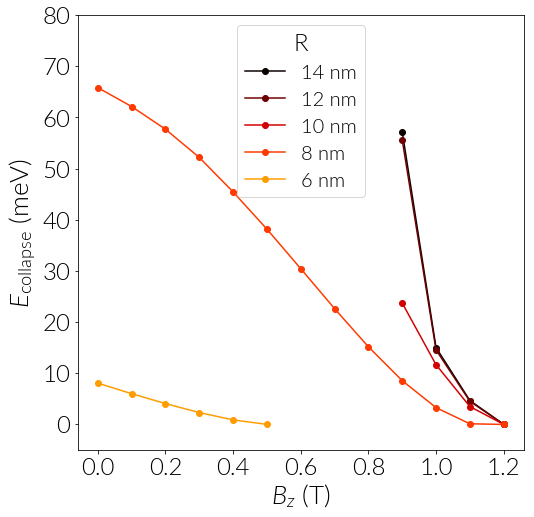

In [7]:
# B_range = np.arange(0, 2001, 100)

cm_subsection = np.linspace(0.4, 1, len(R_range)) 
cm_colors = [matplotlib.cm.hot_r(x) for x in cm_subsection][-1::-1]

f = plt.figure()
ax = f.add_subplot(111)

for i, R in enumerate(R_range):
    
    if R == 6:
        fields_range = slice(0, 6)
    elif R >= 10:
        fields_range = slice(9, None)
    else:
        fields_range = slice(0, None)
        
    ax.plot(B_range[fields_range] * 1e-3, energy_barriers_map[R][fields_range], 'o-', 
            color=cm_colors[i], label='{} nm'.format(R))

ax.set_xticks(B_range[::2] * 1e-3)
ax.set_xticklabels(B_range[::2] * 1e-3)
    
ax.legend(title='R', 
          # loc=(0.05, 0.36),
          loc=0)

ax.set_ylabel(r'$E_{\mathrm{collapse}}$ (meV)')
ax.set_xlabel(r'$B_{z}$ (T)')

ax.set_ylim(-5, 80)

# plt.savefig('hexagons_nebm_R_B_skyrmion-collapse-energy-barrier.pdf',
#             bbox_inches='tight')

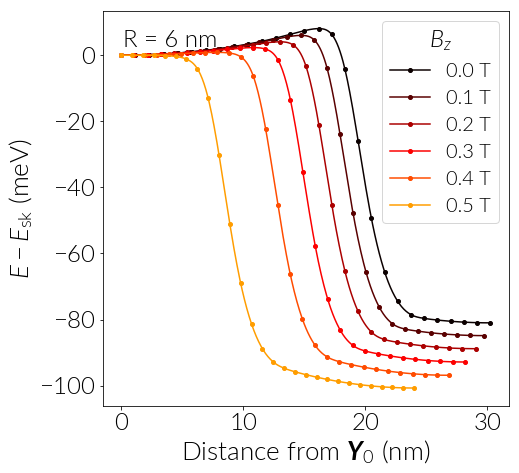

In [8]:
B_range = np.arange(0, 501, 100)

cm_subsection = np.linspace(0.4, 1, len(B_range[::])) 
cm_colors = [matplotlib.cm.hot_r(x) for x in cm_subsection][-1::-1]

f = plt.figure(figsize=(16, 16))

for j, R in enumerate([6]):
    ax = f.add_subplot(2, 2, j + 1)

    ps = []

    for i, B in enumerate(B_range[::]):
        p, = ax.plot(distances[R][B], energy_bands[R][B], 'o', color=cm_colors[i],
                label='{:.1f} T'.format(B * 1e-3),
                ms=4
                )
        ps.append(p)

        p, = ax.plot(energy_bands_interp[R][B][:, 0], energy_bands_interp[R][B][:, 1],
                '-', color=cm_colors[i],
                # label='{:.1f} T'.format(B * 1e-3)
                )
        ps.append(p)
        
    ax.set_xlabel(r'Distance from $\mathbf{Y}_{0}$ (nm)')
    ax.set_ylabel(r'$E-E_{\mathrm{sk}}$ (meV)')

    ax.text(0.05, 0.95, 'R = {} nm'.format(R), horizontalalignment='left',
            verticalalignment='top', transform=ax.transAxes, 
            fontsize=24, rotation=0)

    if j == 0:
        ax.legend(zip(ps[::2], ps[1::2]), [pl.get_label() for pl in ps[::2]],
                  title=r'$B_{z}$')
        
# plt.savefig('hexagons_nebm_R_B_skyrmion-escape-energy-bands.pdf',
#             bbox_inches='tight')

Energy bands for weak fields, $B_{z}\leq0.8\,\,\text{T}$

We can try to observe these transitions:

In [6]:
import nebm_plot_tools.nebm_plot_tools as npt
from IPython.display import Image

/home/david/anaconda3/lib/python3.5/site-packages/nebm_plot_tools/nebm_plot_tools.py:14: UserWarning: The Energy scale is in Joules. If you want to use a different energy scale, you can redefine the neb_plot_functions.scale variable and, to change the labels, use the neb_plot_functions.scale_label variable. In this way, the energy data will be divided by *scale*, e.g. 
 import nebm_plot_tools as npt 
npt.scale = 1000 
npt.scale_label = 'kJ' 
  warnings.warn(imp_message)


In [53]:
base_folder = 'hexagonal_system/NEBM/nebm_2Dhex_hexagons_PdFe-Ir_tgt-st-up_sk-down_B-sweep_DT/'

def last_GNEBM_state(R, B):
    _folder = base_folder + 'vtks/nebm_2Dhex_hexagon_R{}nm_PdFe-Ir_tgt-st-up_sk_down_B{}mT_CI-GNEBM'.format(R, B)
    _folder = sorted(glob.glob(_folder + '*'),
                     key=lambda f: int(re.search('(?<=GNEBM_)\d+', f).group(0)))[-1]
    return os.path.basename(_folder)

In [112]:
for B in [600]:
    npt.plot_mayavi2(last_GNEBM_state(8, B), 
                     [0, 12, 14, 15, 16, 17, 18, 19, 20, 21, 23, 27],
                     cmap='YlOrRd',
                     # reversed_map=True,
                     gridn='4x3', 
                     rel_folder=base_folder,
                     savef='grid.png', 
                     text_fontsize=120, 
                     camera_distance=26,
                     zoom=3,
                     annotate_numbers=False
                     )

/home/david/anaconda3/lib/python3.5/site-packages/tvtk/array_handler.py:268: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


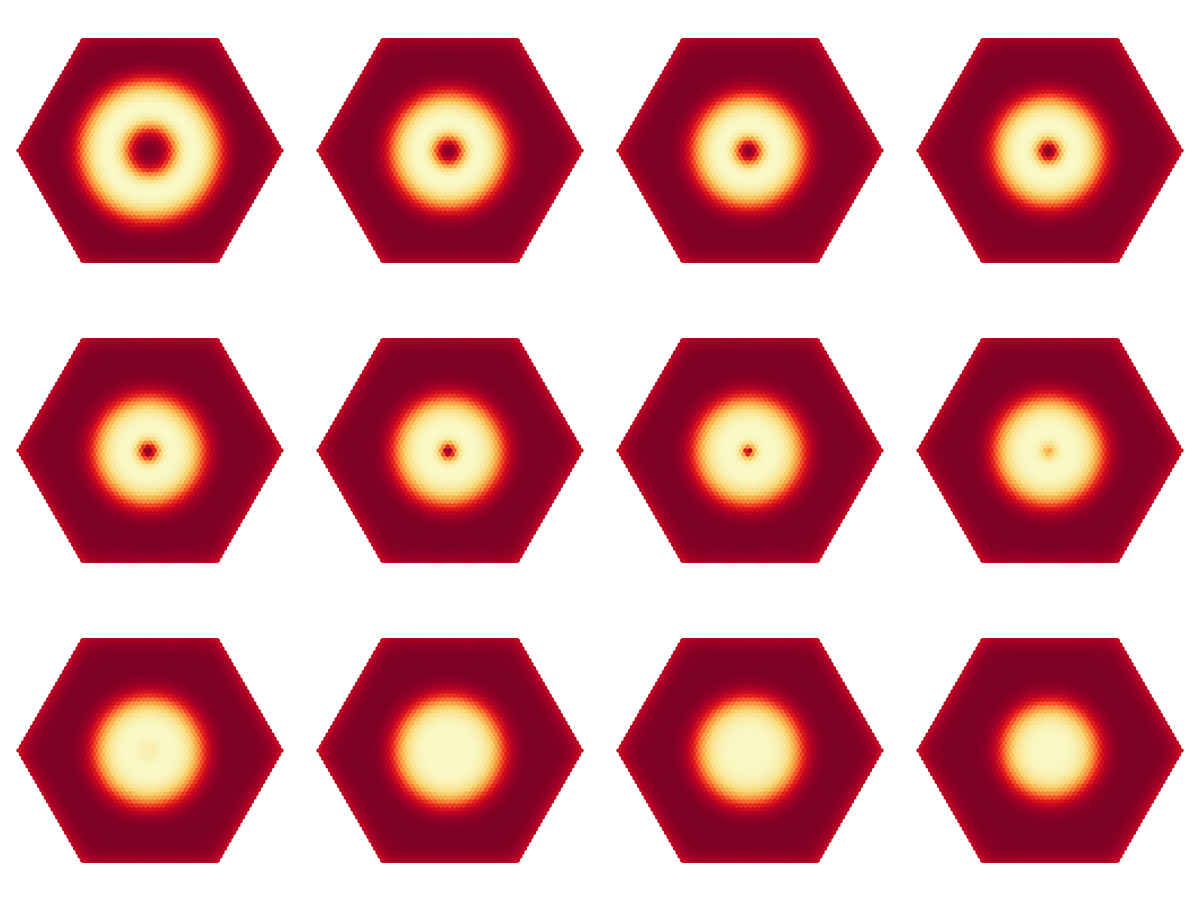

In [113]:
Image(os.path.join('png', last_GNEBM_state(8, 600), 'grid.png'), width=500)

# Ferromagnetic boundaries

In [9]:
base_folder = 'hexagonal_system/NEBM/nebm_2Dhex_hexagons_PdFe-Ir_tgt-st-up_sk-down_B-sweep_pinned_boundary_DT/'

energy_barriers_pinbs = {}
energy_bands_pinbs = {}
distances_pinbs = {}
energy_bands_interp_pinbs = {}

R_range = np.array([14, 12, 10, 8, 6])
B_range = np.arange(0, 1201, 100)

for R in R_range:
    
    energy_barriers_pinbs[R] = {}
    energy_bands_pinbs[R] = {}
    distances_pinbs[R] = {}
    energy_bands_interp_pinbs[R] = {}
    
    for B in B_range:
        
        if (R > 8 and B < 900):
            continue
        
        ndt_file = np.loadtxt(base_folder + 'ndts/nebm_2Dhex_hexagon_R{}nm_PdFe-Ir_tgt-st-up_sk_down_B{}mT_CI-GNEBM_energy.ndt'.format(R, B))
        last_energy_band = ndt_file[-1][1:]
        last_energy_band = (last_energy_band - last_energy_band[0]) / C.meV
        
        dYs_file = np.loadtxt(base_folder + 'ndts/nebm_2Dhex_hexagon_R{}nm_PdFe-Ir_tgt-st-up_sk_down_B{}mT_CI-GNEBM_dYs.ndt'.format(R, B))
        dYs_file = np.append([0], dYs_file[-1][1:])
        
        dat_file = np.loadtxt(base_folder + 'dats/nebm_2Dhex_hexagon_R{}nm_PdFe-Ir_tgt-st-up_sk_down_B{}mT_CI-GNEBM_interpolation.dat'.format(R, B))
        dat_file[:, 1] = (dat_file[:, 1] - dat_file[:, 1][0]) / C.meV
        
        energy_bands_pinbs[R][B] = last_energy_band
        energy_barriers_pinbs[R][B] = np.max(last_energy_band)
        distances_pinbs[R][B] = np.cumsum(dYs_file)
        energy_bands_interp_pinbs[R][B] = dat_file - dat_file[0]

In [10]:
B_range = np.arange(0, 1201, 100)
energy_barriers_map_pinbs = {}

for i, R in enumerate(R_range):
    energy_barriers_map_pinbs[R] = np.zeros(len(B_range))
    for j, B in enumerate(B_range):
        if R > 8 and B < 900:
            continue
        energy_barriers_map_pinbs[R][j] = energy_barriers_pinbs[R][B]

(-5, 80)

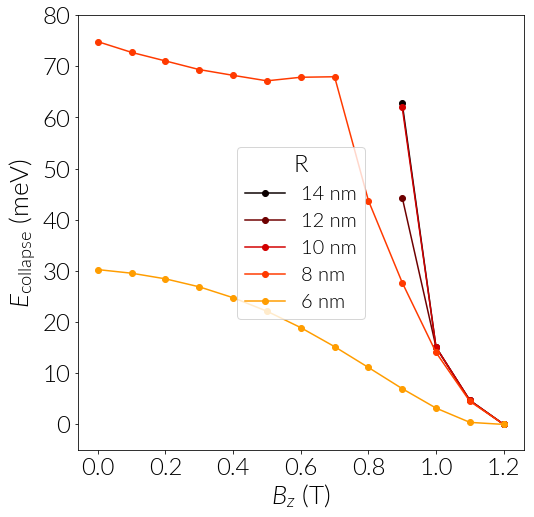

In [11]:
cm_subsection = np.linspace(0.4, 1, len(R_range)) 
cm_colors = [matplotlib.cm.hot_r(x) for x in cm_subsection][-1::-1]

f = plt.figure()
ax = f.add_subplot(111)

for i, R in enumerate(R_range):
    
    if R == 6:
        fields_range = slice(0, None)
    elif R > 8:
        fields_range = slice(9, None)
    else:
        fields_range = slice(0, None)    
         
    ax.plot(B_range[fields_range] * 1e-3, energy_barriers_map_pinbs[R][fields_range], 'o-', 
            color=cm_colors[i], label='{} nm'.format(R))
    
ax.set_xticks(B_range[::2] * 1e-3)
ax.set_xticklabels(B_range[::2] * 1e-3)
    
ax.legend(title='R', 
          # loc=(0.05, 0.36),
          loc=0)

ax.set_ylabel(r'$E_{\mathrm{collapse}}$ (meV)')
ax.set_xlabel(r'$B_{z}$ (T)')

ax.set_ylim(-5, 80)

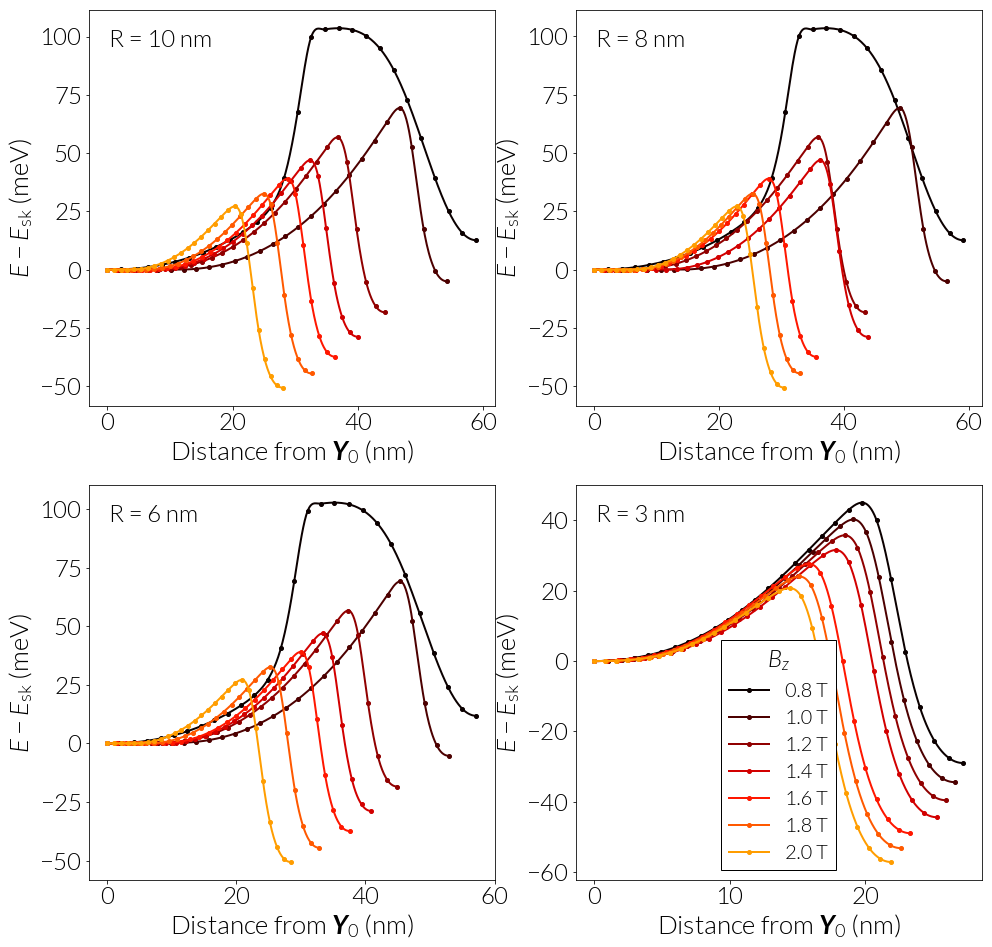

In [148]:
B_range = np.arange(800, 2001, 100)

cm_subsection = np.linspace(0.4, 1, len(B_range[::2])) 
cm_colors = [matplotlib.cm.hot_r(x) for x in cm_subsection][-1::-1]

f = plt.figure(figsize=(16, 16))

for j, R in enumerate([10, 8, 6, 3]):
    ax = f.add_subplot(2, 2, j + 1)

    ps = []

    for i, B in enumerate(B_range[::2]):
        p, = ax.plot(distances_pinbs[R][B], energy_bands_pinbs[R][B], 'o', color=cm_colors[i],
                label='{:.1f} T'.format(B * 1e-3),
                ms=4
                )
        ps.append(p)

        p, = ax.plot(energy_bands_interp_pinbs[R][B][:, 0], energy_bands_interp_pinbs[R][B][:, 1],
                '-', color=cm_colors[i],
                # label='{:.1f} T'.format(B * 1e-3)
                )
        ps.append(p)
        
    ax.set_xlabel(r'Distance from $\mathbf{Y}_{0}$ (nm)')
    ax.set_ylabel(r'$E-E_{\mathrm{sk}}$ (meV)')

    ax.text(0.05, 0.95, 'R = {} nm'.format(R), horizontalalignment='left',
            verticalalignment='top', transform=ax.transAxes, 
            fontsize=24, rotation=0)

    if j == 3:
        ax.legend(zip(ps[::2], ps[1::2]), [pl.get_label() for pl in ps[::2]],
                  title=r'$B_{z}$')
        
# plt.savefig('hexagons_nebm_R_B_skyrmion-escape-energy-bands.pdf',
#             bbox_inches='tight')

In [27]:
def last_GNEBM_state_pinbs(R, B):
    base_folder = 'hexagonal_system/NEBM/nebm_2Dhex_hexagons_PdFe-Ir_tgt-st-up_sk-down_B-sweep_pinned_boundary_DT/'
    _folder = base_folder + 'vtks/nebm_2Dhex_hexagon_R{}nm_PdFe-Ir_tgt-st-up_sk_down_B{}mT_CI-GNEBM'.format(R, B)
    _folder = sorted(glob.glob(_folder + '*'),
                     key=lambda f: int(re.search('(?<=GNEBM_)\d+', f).group(0)))[-1]
    return os.path.basename(_folder)

In [29]:
npt.npt_cm.BuYlOr

array([[0.01176471, 0.12941176, 0.28627451, 1.        ],
       [0.01949688, 0.13623267, 0.28993825, 1.        ],
       [0.02722904, 0.14305358, 0.293602  , 1.        ],
       ...,
       [0.99996261, 0.28201551, 0.01181807, 1.        ],
       [0.9999813 , 0.27630187, 0.00590904, 1.        ],
       [1.        , 0.27058824, 0.        , 1.        ]])

In [114]:
for B in [600]:
    npt.plot_mayavi2(last_GNEBM_state_pinbs(8, B), 
                     [0, 5, 6, 8, 9, 10, 11, 17, 21, 23, 25, 27], 
                     cmap='YlOrRd',
                     # reversed_map=True,
                     gridn='4x3', 
                     rel_folder='hexagonal_system/NEBM/nebm_2Dhex_hexagons_PdFe-Ir_tgt-st-up_sk-down_B-sweep_pinned_boundary_DT/',
                     savef='grid.png',
                     text_fontsize=120, 
                     camera_distance=26,
                     zoom=3,
                     annotate_numbers=False
                     )

/home/david/anaconda3/lib/python3.5/site-packages/tvtk/array_handler.py:268: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


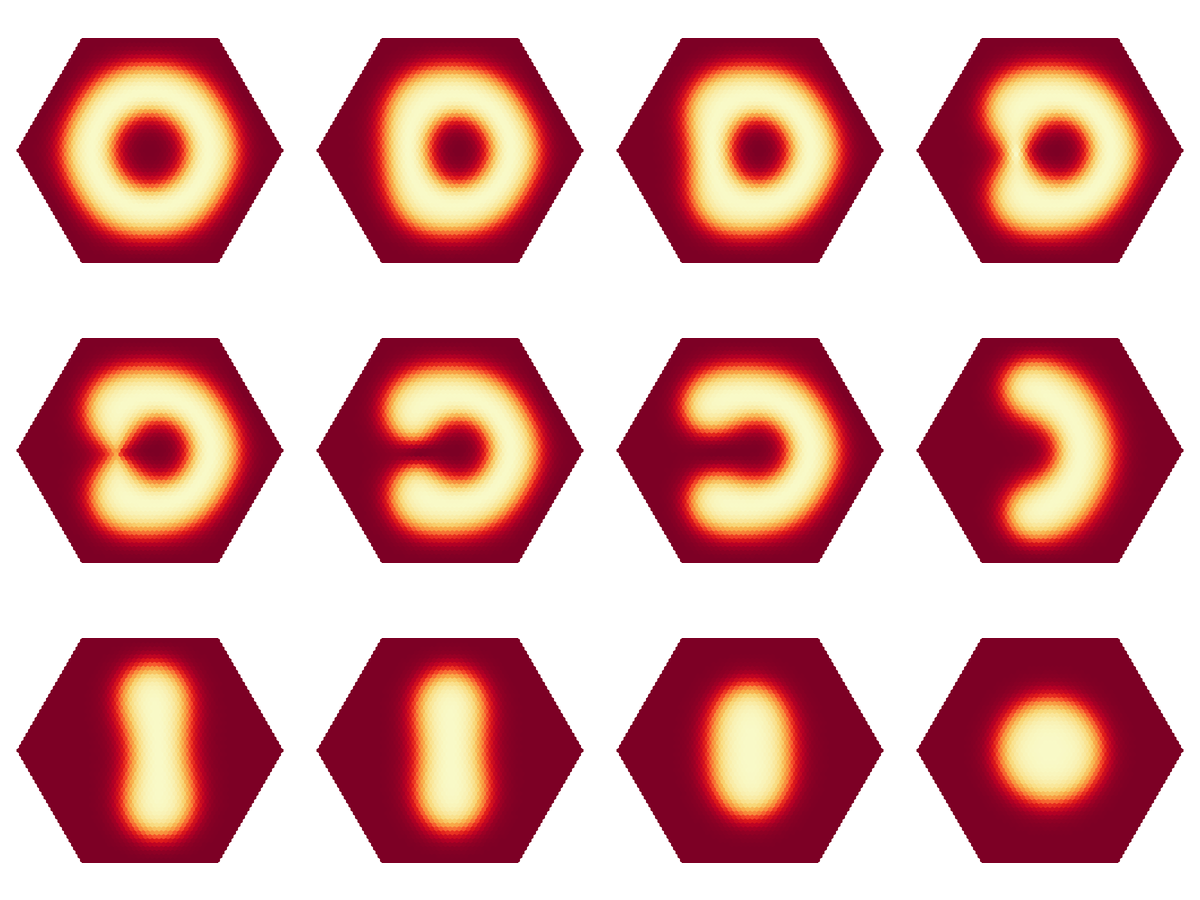

In [115]:
Image(os.path.join('png', last_GNEBM_state_pinbs(8, 600), 'grid.png'), width=500)

# Comparison

In [52]:
matplotlib.rcParams['font.size'] = 32
matplotlib.rcParams['xtick.labelsize'] = 32
matplotlib.rcParams['ytick.labelsize'] = 32
matplotlib.rcParams['legend.fontsize'] = 28
matplotlib.rcParams['axes.labelsize'] = 32

In [ ]:
B_range = np.arange(0, 1201, 100)

cm_subsection = np.linspace(0.4, 1, len(R_range)) 
cm_colors = [matplotlib.cm.hot_r(x) for x in cm_subsection][-1::-1]

f = plt.figure(figsize=(16, 8))

ax1 = f.add_subplot(121)
for i, R in enumerate(R_range):
    if R == 6:
        fields_range = slice(0, 6)
    elif R >= 10:
        fields_range = slice(9, None)
    else:
        fields_range = slice(0, None)    
        
    ax1.plot(B_range[fields_range] * 1e-3, energy_barriers_map[R][fields_range], 'o-', 
             color=cm_colors[i], label='{} nm'.format(R),
             markerfacecolor='None', ms=16 - 2 * (i + 1), mew=1.5
             )
    
         
    
ax2 = f.add_subplot(122, sharey=ax1)    
for i, R in enumerate(R_range):
    if R == 6:
        fields_range = slice(0, None)
    elif R >= 10:
        fields_range = slice(9, None)
    else:
        fields_range = slice(0, None)    
    ax2.plot(B_range[fields_range] * 1e-3, energy_barriers_map_pinbs[R][fields_range], 'o-', 
             color=cm_colors[i], label='{} nm'.format(R),
             markerfacecolor='None', ms=16 - 2 * (i + 1), mew=1.5
             )


ax1.set_title(r'$\mathrm{Free}\,\,\mathrm{boundaries}$', fontsize=32)    
ax1.set_xticks(B_range[::2] * 1e-3)
ax1.set_xticklabels(B_range[::2] * 1e-3)
for i in list(range(1, 6, 2)):
    ax1.get_xticklabels()[i].set_visible(False)
ax1.set_ylabel(r'$E_{\mathrm{target\,\,\,state \rightarrow skyrmion}}$ (meV)')
ax1.set_xlabel(r'$B_{z}$ (T)')
ax1.grid()
ax1.text(0.95, 0.95, '(a)' , horizontalalignment='right', verticalalignment='top',
         transform=ax1.transAxes, fontweight='bold', fontsize=32)
# ax1.legend(title='R', loc=(0.02, 0.2))
ax1.legend(ncol=5, loc='lower left', bbox_to_anchor=(0, 1.1, 2.0, 1.0),
           mode='expand', borderaxespad=-0.1, fontsize=28,
           handletextpad=0.6
           )
ax1.set_xlim(-0.1, 1.3)

ax2.set_title(r'$\mathrm{Ferromagnetic}\,\,\mathrm{rim}$', fontsize=32)
ax2.set_xticks(B_range[::2] * 1e-3)
ax2.set_xticklabels(B_range[::2] * 1e-3)
for i in list(range(1, 6, 2)):
    ax2.get_xticklabels()[i].set_visible(False)
ax2.set_xlabel(r'$B_{z}$ (T)')
ax2.grid()
plt.setp(ax2.get_yticklabels(), visible=False)
ax2.text(0.95, 0.95, '(b)' , horizontalalignment='right', verticalalignment='top',
         transform=ax2.transAxes, fontweight='bold', fontsize=32)
ax2.set_xlim(-0.1, 1.3)

plt.subplots_adjust(wspace=0)

# -----------------------------------------------------------------------------

box = ax1.get_position()
axIm1 = plt.axes([box.x0, -0.27, box.width, box.height - 0.5])
axIm1.set_xticks([])
axIm1.set_yticks([])
axIm1.imshow(plt.imread('inkscape/target-st_sk_transition/transition.png'))
axIm1.set_xlabel(r'R = 8 nm      $B_{z}=0.6\,\mathrm{T}$')
ax1.plot(0.6, energy_barriers_map[8][6], 's',
         color='C5', markerfacecolor='None', ms=15, mew=3
         )

box = ax2.get_position()
axIm2 = plt.axes([box.x0, -0.27, box.width, box.height - 0.5])
axIm2.set_xticks([])
axIm2.set_yticks([])
axIm2.imshow(plt.imread('inkscape/target-st_sk_transition/transition_PBS.png'))
axIm2.set_xlabel(r'R = 8 nm      $B_{z}=0.6\,\mathrm{T}$')
ax2.plot(0.6, energy_barriers_map_pinbs[8][6], 's',
         color='C5', markerfacecolor='None', ms=15, mew=3
         )

# Draw a colorbar
box = axIm1.get_position()
axCb = plt.axes([box.x0 - 0.015, -0.24, 0.01, 0.195])
cb = matplotlib.colorbar.ColorbarBase(axCb, plt.cm.YlOrRd, orientation="vertical",
                                      ticks=[-1, 0, 1], 
                                      norm=matplotlib.colors.Normalize(vmin=-1, vmax=1))
cb.set_label(r'$s_{z}$', rotation=90, y=.5, labelpad=-80, fontsize=40)
axCb.yaxis.set_ticks_position('left')

# -----------------------------------------------------------------------------

plt.savefig('hexagons_nebm_R_B_tgt-state-skyrmion_energy-barrier_FreeBS-FMRim.pdf', 
            bbox_inches='tight', dpi=300)